In [283]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import pandas as pd
from scipy.interpolate import interp1d

In [284]:
# LOAD in fixed simulation parameters
sim_z = np.loadtxt('/Users/kulkarniad/muram/z.csv')
wl = fits.open('wl.fits')[0].data
NLAMBDA = 472
NZ = 64
NX = 50
NY = 50

In [346]:
#find indices of strontium wl
jumps = np.where(np.diff(wl)>10)
ni = jumps[0][0] + 1
nf = jumps[0][1] + 1

In [285]:
# Create collision depolarization cube.
def load_depol_array():
    data = pd.read_csv('depol.csv') # copy of Figure 6 of aleman and trujillo bueno
    z = data.iloc[:,0]*1e3 # z is in units of km
    delta = data.iloc[:,1] # delta is unitless
    delta_interp = interp1d(z,delta,fill_value= 'extrapolate')
    delta_array = delta_interp(sim_z)
    delta_cube = np.zeros((NZ,NY,NX))
    # Interpolate this function over MURaM z values
    for i in range(NX):
        for j in range(NY):
            delta_cube[:,j,i] = delta_array
    return delta_cube

In [15]:
delta_cube = load_depol_array()

'delta_cube' = $\delta_u^{(2)}$

In [18]:
delta_cube.shape

(64, 50, 50)

Text(0.5, 0, '$z (km) $')

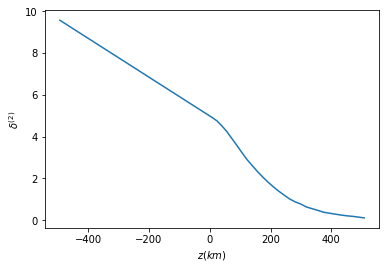

In [17]:
plt.plot(sim_z,delta_cube[:,0,0])
plt.ylabel('$\delta ^{(2)}$')
plt.xlabel('$z (km) $')

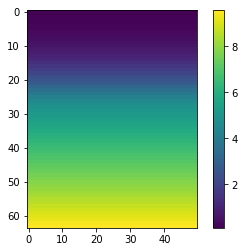

In [6]:
plt.imshow(delta_cube[:,:,32])
plt.colorbar()

In [22]:
# READ IN OPACITIES AND EMISSIVITIES
data = fits.open('small/opac_l.fits')
opac_l = data[0].data
data = fits.open('small/opac_c.fits')
opac_c = data[0].data

data = fits.open('small/emis_l.fits')
emis_l = data[0].data
data = fits.open('small/emis_c.fits')
emis_c = data[0].data

In [24]:
# LINE SOURCE FUNCTION
S_l = emis_l/opac_l

In [25]:
#GLOBAL VARIABLES
TRT = 2.0*np.sqrt(2) # 2 sqrt(2)
Aij = 28180897.721018 # straight out of RH from line->Aji note that this is a factor 5 different from NIST's value

In [26]:
class Opacity:
    def __init__(self,dir_loc):        
        data = fits.open(dir_loc+'opac_l.fits')
        self.opac_l = data[0].data
        data = fits.open(dir_loc+'opac_c.fits')
        self.opac_c = data[0].data

        data = fits.open(dir_loc+'emis_l.fits')
        self.emis_l = data[0].data
        data = fits.open(dir_loc+'emis_c.fits')
        self.emis_c = data[0].data
            

In [39]:
fits.open('small/opac_c.fits')[0].data.shape

(472, 64, 50, 50)

In [31]:
def epsilon(dir_loc):
    cij = np.loadtxt(dir_loc+'Cij8.txt').reshape(NZ,NY,NX)
    return cij/(cij+Aij)
    

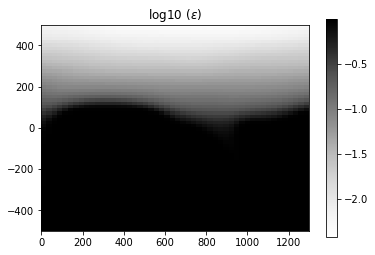

In [33]:
eps_small = epsilon('small/')
eps_smoothr = epsilon('smooth_reconstruct//')


plt.imshow(np.log10(eps_small[:,10,:]),cmap='Greys',extent=[0,1300,-500,500])
plt.colorbar()
plt.title('log10 ($ \epsilon $)')
plt.show()

$\varepsilon$ ranges from $\sim 1$ down low in the atmosphere to less than $0.01$ near the top of the atmosphere

In [35]:
sorted(glob.glob('small/'+'/*txt'))

['small/Cij8.txt',
 'small/J00.txt',
 'small/J20.txt',
 'small/imJ21.txt',
 'small/imJ22.txt',
 'small/reJ21.txt',
 'small/reJ22.txt']

In [44]:
class Sphr_tensors:
    def __init__(self,dir_loc):
        # spherical J tensors
        self.j00 = np.loadtxt(dir_loc+'J00.txt').reshape(NZ,NY,NX)
        self.j20 = np.loadtxt(dir_loc+'J20.txt').reshape(NZ,NY,NX)
        self.imj21 = np.loadtxt(dir_loc+'imJ21.txt').reshape(NZ,NY,NX)
        self.imj22 = np.loadtxt(dir_loc+'imJ22.txt').reshape(NZ,NY,NX)
        self.rej21 = np.loadtxt(dir_loc+'reJ21.txt').reshape(NZ,NY,NX)
        self.rej22 = np.loadtxt(dir_loc+'reJ22.txt').reshape(NZ,NY,NX)

In [166]:
class Source_function:
    def __init__(self,dir_loc):
        
        st = Sphr_tensors(dir_loc)       
        eps = epsilon(dir_loc)
        delta = load_depol_array()
        
        # opacity parameters
        self.opcty = Opacity(dir_loc)        
        self.r = self.opcty.opac_l / (self.opcty.opac_l  + self.opcty.opac_c )
        self.source_l = self.opcty.emis_l/self.opcty.opac_l
        self.source_c = self.opcty.emis_c/self.opcty.opac_c
    
        self.s00 = self.source_l # define this to be the line source function
        
        # eq 5 of del pino aleman (DPA)
        self.s20   = (1-eps)/(1+delta*(1-eps)) * st.j20
        self.res21 = (1-eps)/(1+delta*(1-eps)) * st.rej21
        self.res22 = (1-eps)/(1+delta*(1-eps)) * st.rej22        
        self.ims21 = (1-eps)/(1+delta*(1-eps)) * st.imj21 * (-1.0)
        self.ims22 = (1-eps)/(1+delta*(1-eps)) * st.imj22 * (-1.0)
        
    # Line source functions 
    #(eq 6 of DPA)
    def si_line(self,mu,azi):
        c1 = 1/TRT*(3*mu**2 - 1)
        c2 = np.sqrt(3)*mu*np.sqrt(1-mu**2)
        c3 = (np.sqrt(3)/2) * (1-mu**2)        

        out = self.s00 + c1*self.s20 
        out-= c2*(self.res21*np.cos(azi)-self.ims21*np.sin(azi)) 
        out+= c3*(self.res22*np.cos(2*azi) - self.ims22*np.sin(2*azi)) 

        return out

    #(eq 7 of DPA)
    def sq_line(self,mu,azi):
        c1 = 3/TRT*(mu**2 - 1)
        c2 = np.sqrt(3)*mu*np.sqrt(1-mu**2)
        c3 = (np.sqrt(3)/2) * (1+mu**2)

        out = c1*self.s20 
        out-= c2*(self.res21*np.cos(azi)-self.ims21*np.sin(azi)) 
        out-= c3*(self.res22*np.cos(2*azi)-self.ims22*np.sin(2*azi))
        
        return out

    #(eq 8 of DPA)
    def su_line(self,mu,azi):
        c1 = np.sqrt(1-mu**2)
        
        out = c1*(self.res21*np.sin(azi) + self.ims21*np.cos(azi)) 
        out += mu*(self.res22*np.sin(2*azi) + self.ims22*np.cos(2*azi))

        out *= np.sqrt(3.0)
        return out
    
# Now Calculate source functions of I, Q U:         
    def source_i(self,mu,azi):
        return self.r*self.si_line(mu,azi) + (1-self.r)*self.source_c

    def source_q(self,mu,azi):
        return self.r*self.sq_line(mu,azi)  # check that some wierd broadcasting is not going on here!

    def source_u(self,mu,azi):
        return self.r*self.su_line(mu,azi) 

In [167]:
src_fnc = Source_function(direct)

Source funcs are loaded and ready to rumble!

###  Now try and solve radiative transfer eqn. We need to get optical depths

In [286]:
direct = 'smooth_reconstruct/'

In [287]:
opac = Opacity(direct)

In [288]:
total_opac = opac.opac_l+opac.opac_c
from scipy.integrate import cumtrapz

In [289]:
# calculate tau by intergrating opacity
tau_cube = np.zeros((NLAMBDA,NZ,NY,NX))
for l in range(NLAMBDA):
    for i in range(NX):
        for j in range(NY):
            tau_cube[l,:,j,i] = cumtrapz(total_opac[l,:,j,i], x=sim_z*1e3,initial=-1e-5) * (-1.0)
            

In [290]:
tau_cube.shape

(472, 64, 50, 50)

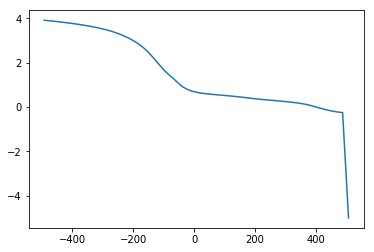

In [291]:
plt.plot(sim_z,np.log10(tau_cube[30,:,3,3]))

Tau profiles look good

In [79]:
src_fnc = Source_function(direct)

In [80]:
src_fnc.source_i(0.0,0.0).shape

(472, 64, 50, 50)

In [81]:
# FORMAL solver for vertical rays

def sc_formal_solver(I_upwind,delta,S_upwind,S_local):
 
    expd = np.exp(-delta)
    w_local = 1.0 - 1.0/delta * (1.0 - expd)
    w_upwind = -expd + 1.0/delta * (1.0 - expd)
 
    I_local = I_upwind * expd + w_local * S_local + w_upwind * S_upwind
 
    return I_local

In [292]:
s_col = src_fnc.source_i(0.0,0.0)[30,:,30,30]

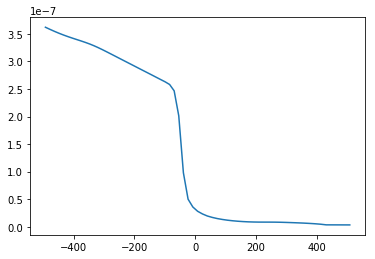

In [295]:
plt.plot(sim_z,s_col)

In [297]:
I_cube = np.zeros((NLAMBDA,NZ,NY,NX))
src_fnc = Source_function(direct)
S = src_fnc.source_i(1.0,0.0)
I_cube[:,-1,:,:] = S[:,-1,:,:]  # Set S = I at bottom of atmosphere

for l in range(NLAMBDA):
    for j in range(NY):
        for i in range(NX):
            for d in np.arange(NZ-2,-1,-1): # from bottom to top (d is decreasing)
                dtau = tau_cube[l,d+1,j,i] - tau_cube[l,d,j,i]
                I_cube[l,d,j,i] = sc_formal_solver(I_cube[l,d+1,j,i],dtau,S[l,d+1,j,i],S[l,d,j,i])

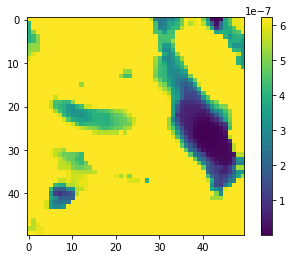

In [298]:
plt.imshow(I_cube[0,61,:,:])
plt.colorbar()

In [299]:
import time

In [300]:

start = time.time()
Q_cube = np.zeros((NLAMBDA,NZ,NY,NX))
src_fnc = Source_function(direct)
S = src_fnc.source_q(1.0,0.0)
Q_cube[:,-1,:,:] = S[:,-1,:,:]  # Set S = I at bottom of atmosphere

for l in range(NLAMBDA):
    for j in range(NY):
        for i in range(NX):
            for d in np.arange(NZ-2,-1,-1): # from bottom to top (d is decreasing)
                dtau = tau_cube[l,d+1,j,i] - tau_cube[l,d,j,i]
                Q_cube[l,d,j,i] = sc_formal_solver(Q_cube[l,d+1,j,i],dtau,S[l,d+1,j,i],S[l,d,j,i])
                
end = time.time()
print(end - start)

537.7720999717712


In [301]:
U_cube = np.zeros((NLAMBDA,NZ,NY,NX))
src_fnc = Source_function(direct)
S = src_fnc.source_u(1.0,0.0)
U_cube[:,-1,:,:] = S[:,-1,:,:]  # Set S = I at bottom of atmosphere

for l in range(NLAMBDA):
    for j in range(NY):
        for i in range(NX):
            for d in np.arange(NZ-2,-1,-1): # from bottom to top (d is decreasing)
                dtau = tau_cube[l,d+1,j,i] - tau_cube[l,d,j,i]
                U_cube[l,d,j,i] = sc_formal_solver(U_cube[l,d+1,j,i],dtau,S[l,d+1,j,i],S[l,d,j,i])

In [317]:
def view_signal(wl_index):
    plt.imshow(I_cube[wl_index,0],cmap='hot')
    plt.title('Intensity ' + str(round(wl[wl_index],2)) + ' nm')
    plt.clim(np.min(I_cube[wl_index,0]),np.max(I_cube[wl_index,0]))
    plt.colorbar()
    plt.show()

    plt.subplots(figsize=(20, 10))
    plt.subplot(121)
    plt.title('Q/I')
    plt.imshow(Q_cube[wl_index,0]/I_cube[wl_index,0],cmap='bwr')
    plt.colorbar()
    plt.clim(-0.02,0.02)


    plt.subplot(122)
    plt.title('U/I')
    plt.imshow(U_cube[wl_index,0]/I_cube[wl_index,0],cmap='bwr')
    plt.colorbar()
    plt.clim(-0.02,0.02)
    plt.show()



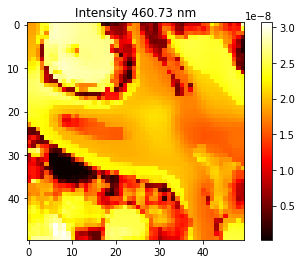

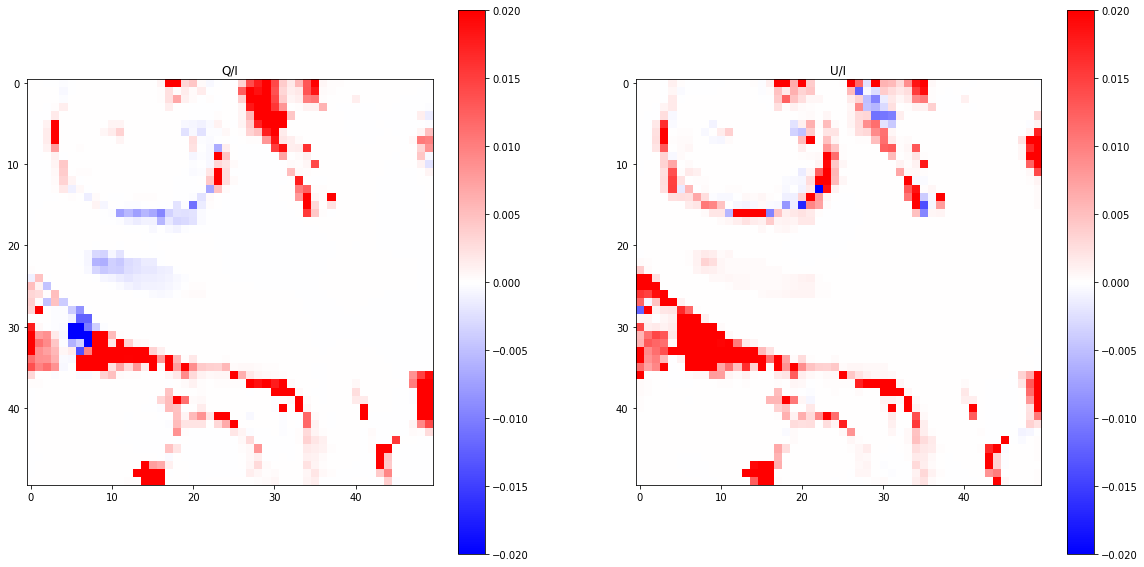

In [318]:
view_signal(25)

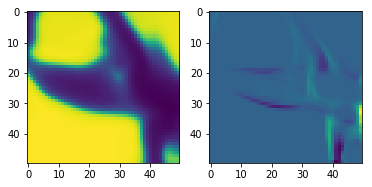

In [274]:
import matplotlib.pyplot as plt
import numpy as np

list1 = np.random.rand(10)*2.1
list2 = np.random.rand(10)*3.0

plt.subplot(1, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
plt.imshow(I_cube[30,30])
plt.subplot(1, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
plt.imshow(Q_cube[30,30])
plt.show()

In [275]:
U_cube.shape

(472, 64, 50, 50)

In [195]:
wl[25]

460.72841549080925

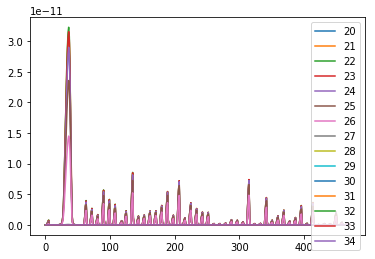

In [194]:
for i in np.arange(20,35):
    plt.plot(Q_cube[:,i,40,0],label = str(i))
    plt.legend()

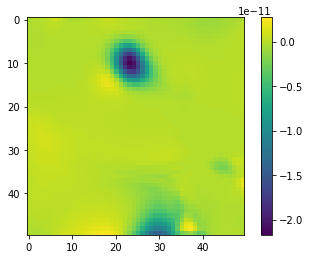

In [201]:
plt.
plt.imshow(Q_cube[25,0,:,:])
plt.colorbar()

In [198]:
Q_cube.shape

(472, 64, 50, 50)

# Comparing reconstructions with original atmosphere

In [471]:
true_I = fits.open('small_I.fits')[0].data
true_Q = fits.open('small_Q.fits')[0].data
true_U = fits.open('small_U.fits')[0].data

recons_I = fits.open('smooth_reconstruct_I.fits')[0].data
recons_Q = fits.open('smooth_reconstruct_Q.fits')[0].data
recons_U = fits.open('smooth_reconstruct_U.fits')[0].data


In [323]:
true_I.shape

(472, 64, 50, 50)

# Scatterplots in intensity

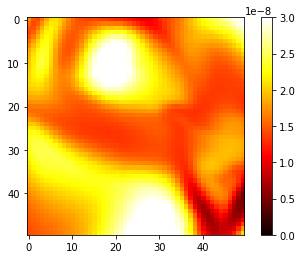

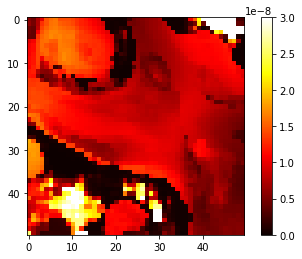

In [374]:
plt.imshow(true_I[int(ni+nf/2),0],cmap='hot')
plt.clim(0,3e-8)
plt.colorbar()
plt.show()
plt.imshow(recons_I[int(ni+nf/2),0],cmap='hot')
plt.clim(0,3e-8)
plt.colorbar()
plt.show()

Text(0.5, 0, 'true')

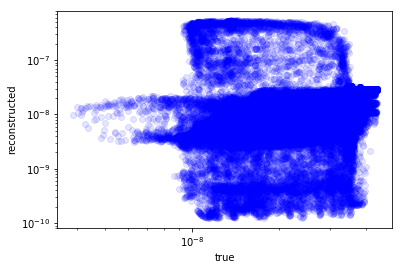

In [367]:
plt.loglog(true_I[ni:nf,0].flatten(),recons_I[ni:nf,0].flatten(),'bo',alpha=0.1)
plt.ylabel('reconstructed')
plt.xlabel('true')
#plt.ylim(0,5e-7)
#plt.xlim(0,1e-7)

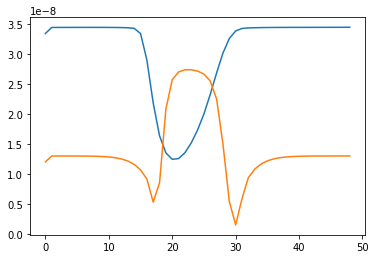

In [451]:
i = np.random.randint(0,50)
j = np.random.randint(0,50)

plt.plot(true_I[ni:nf,0,i,j])
plt.plot(recons_I[ni:nf,0,i,j])

# synthesized intensities look quite different ...

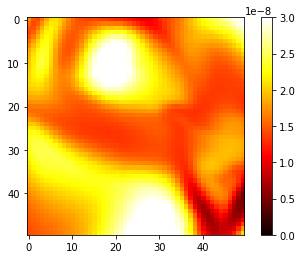

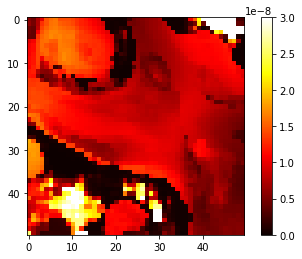

In [431]:
plt.imshow(true_I[int(ni+nf/2),0],cmap='hot')
plt.clim(0,3e-8)
plt.colorbar()
plt.show()
plt.imshow(recons_I[int(ni+nf/2),0],cmap='hot')
plt.clim(0,3e-8)
plt.colorbar()
plt.show()

# Now look at Q

In [ ]:
plt.scatter(true_U[ni:nf,0,2,1])

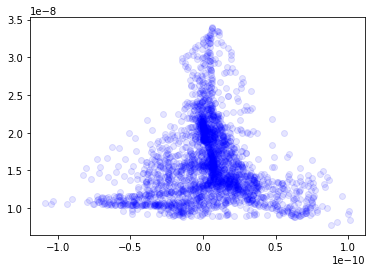

In [472]:
plt.plot(true_U[int(ni*0.5 + nf*0.5),0,:,:],
         true_I[int(ni*0.5 + nf*0.5),0,:,:],'bo',alpha = 0.1)
plt.show()

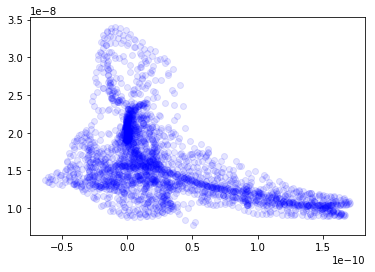

In [473]:
plt.plot(true_Q[int(ni*0.5 + nf*0.5),0,:,:],
         true_I[int(ni*0.5 + nf*0.5),0,:,:],'bo',alpha = 0.1)
plt.show()

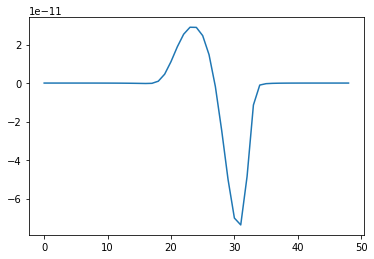

In [448]:
plt.plot(true_Q[ni:nf,0,3,1])

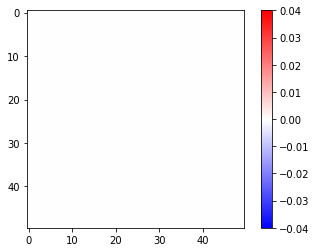

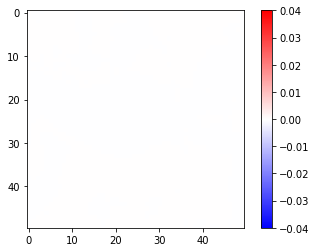

In [436]:
plt.imshow(true_Q[int(ni+nf/2),0],cmap='')
plt.clim(-0.04,0.04)
plt.colorbar()
plt.show()
plt.imshow(recons_Q[int(ni+nf/2),0],cmap='bwr')
plt.colorbar()
plt.clim(-0.04,0.04)
plt.show()

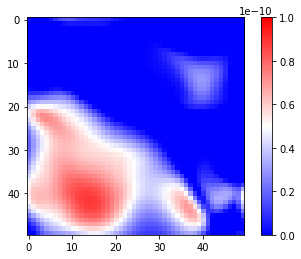

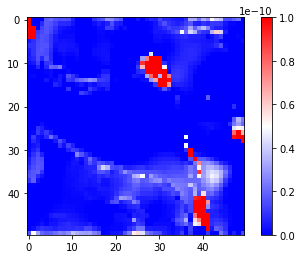

In [475]:
plt.imshow(true_Q[int(ni+nf/2),0],cmap='bwr')
plt.clim(0.0,1e-10)
plt.colorbar()
plt.show()
plt.imshow(recons_Q[int(ni+nf/2),0],cmap='bwr')
plt.colorbar()
plt.clim(0,1e-10)
plt.show()

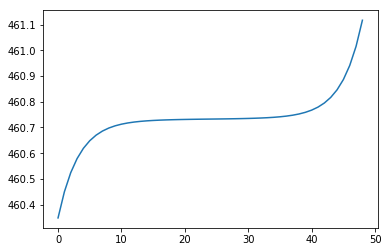

In [350]:
plt.plot(wl[ni:nf])

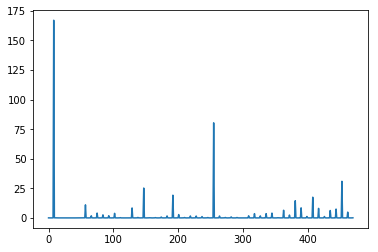

In [333]:
plt.plot(np.diff(wl))

In [334]:
np.where(np.diff(wl)>10)

(array([  8,  57, 147, 192, 255, 381, 408, 453]),)

In [ ]:
plt.scatter(true_I[:])